# Analysis of South African Covid-19 Datasets -  Updated as of 05-Apr-2020

The outbreak of the Covid-19 pandemic has been an unprecendented event in our lives.  While this event is first and foremost a human tragegy, humanity's collective response to this pandememic will shape our lives in the months and years to come.   In order to gain deeper insight into the factors that are shaping our response, be it in the medical, government or social spheres, it is vital to analyse the data that is being gathered as this crises evolves. 
This objective of this data analysis should not only be limited to guiding policy decisions but to also strenghten the spirit of enquiry, curiosity and exploration in our society so that all of us are empowered to ask our own questions and seek answers.

To aid this endevour, this Jupyter notebook makes uses of publicity available data sets and provides a programmatic framework for data analyts and data scientists to explore and visualize the data.    As this notebook evolves, we will also explore further trends and patterns in these data sets that could be used to guide decision making. 



Contributors:  
1. Karthikeyan V,  Wits University and Accenture
2. Mohamed H. Essop, Accenture 
3. Dylan van Zijl, Accenture

# Source of data
Data Science for Social Impact Research Group @ University of Pretoria, Coronavirus COVID-19 (2019-nCoV) Data Repository for South Africa. Available on: https://github.com/dsfsi/covid19za.


# Part 1: Preliminary Data Exploration and Data Wrangling

# Some early questions to be considered
1. How have the number of infections evolved on a daily basis?  How are the infections distributed across the different provinces in SA? 
2. What were the sources of these infections?  Global, local travel or community infections? 
3. What do the demographics of the infected persons tell us?  Does age or gender influence the possibility of getting infected? 
4. What is the trend of deaths that have occured thus far?   How does this trend compare to global trends?   Are there other factors that increase the chances of death when infected such as co-morbidity (or having a pre-existing medical condition)? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# How has the number of infections grown over time? 

In [2]:
df = pd.read_csv('../data/covid19za_provincial_cumulative_timeline_confirmed.csv')
df.head()


date  YYYYMMDD   EC   FS   GP  KZN   LP   MP   NC   NW   WC  UNKNOWN  \
0  05-03-2020  20200305  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0      0.0   
1  07-03-2020  20200307  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0      0.0   
2  08-03-2020  20200308  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0  0.0      0.0   
3  09-03-2020  20200309  0.0  0.0  1.0  6.0  0.0  0.0  0.0  0.0  0.0      0.0   
4  11-03-2020  20200311  0.0  0.0  5.0  7.0  0.0  0.0  0.0  0.0  1.0      0.0   

   total  
0      1  
1      2  
2      3  
3      7  
4     13

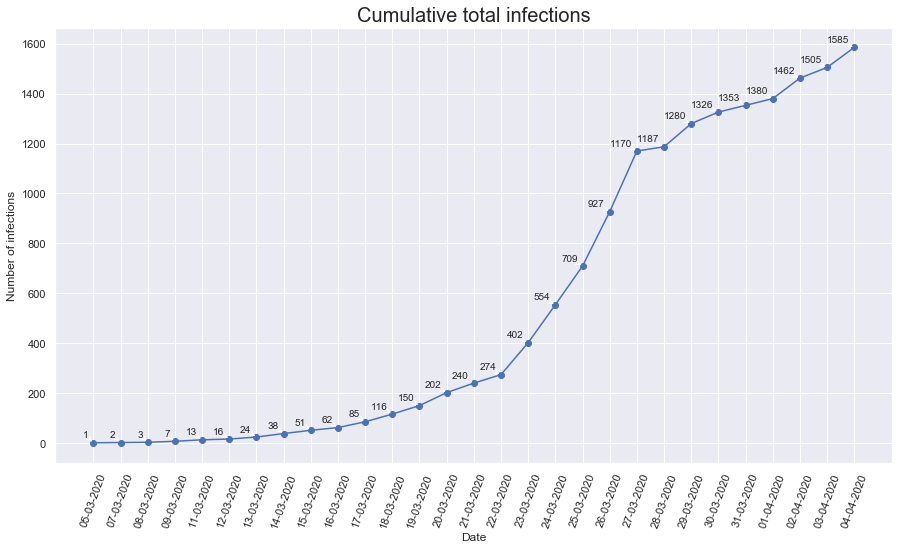

In [3]:
fig = plt.figure(figsize=[15,8]);
cov_date = pd.Series(df.total.values, index=df.date)
plt.xlabel('Date')
plt.tick_params(axis='x', rotation=70)
plt.ylabel('Number of infections')
plt.title('Cumulative total infections', fontsize=20)
for index, row in df.iterrows():
    plt.annotate('{}'.format(row['total']), xy=(row['date'], row['total']), xytext=(-5, 5), ha='right', textcoords='offset points', arrowprops=dict(arrowstyle='->', shrinkA=0))
    #plt.text(row['date'], row['total'], row['total'])
plt.plot(cov_date, 'o-')

## Analysis

### 05-Apr-2020
While it seems that there is a slowdown in the of rate infected cases post 27-Mar, i.e. no longer following an exponential increase, is that really the case, or are the detected infections a function of the number of tests being conducted?    See the daily testing charts below. 

## Taking into account recoveries and deaths

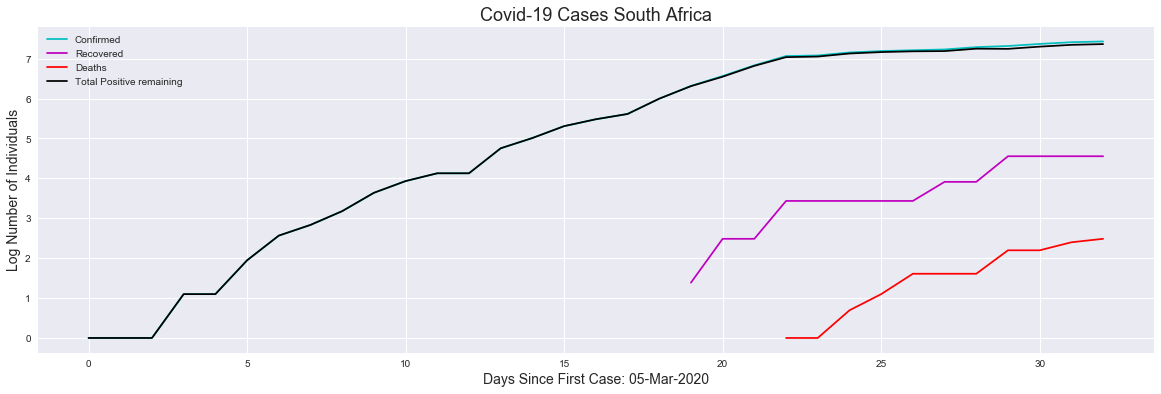

In [14]:
import requests
import csv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import math

# URL to data from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
confirmed_path = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
death_path = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
recovered_path = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'

# plot to be natural or log
log = True

# get south africa data from csv from URL
def get_data(path):
    with requests.Session() as s:
        download = s.get(path)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        lines = list(cr)
        for line in lines:
            if line == lines[0]:
                dates = line[4:]
            if "South Africa" in line:
                item = line[4:]
        # remove new line character from last elements of list
        dates[-1] = dates[-1].strip()
        item[-1] = item[-1].strip()
        item = list(map(lambda x:int(x), item))
        # get dates from m/d/yy to m/d/yyyy
        dates = list(map((lambda x: x[0:-2]+'20'+x[-2:]),dates))
        dates = list(map((lambda x:datetime.datetime.strptime(x,'%m/%d/%Y')),dates))
    return dates, item

# find date where first cases has occured
def find_first(dates, items):
    for i, item in enumerate(items):
        if int(item) == 0:
            continue
        else:
            items = items[i:]
            dates = dates[i:]
            index = i
        return dates, items, index

#function to get number of days from first date
def get_days(dates):
    days = []
    format_str = '%m/%d/%Y'
    d0 = dates[0]
    for date in dates:
        # get the difference in days
        delta = date - d0
        days.append(int(delta.days))
    return days

# get numbers of cases and dates from each dataset
confirmed_dates, confirmed_cases = get_data(confirmed_path)
recovered_dates, recovered_cases = get_data(recovered_path)
death_dates, death_cases = get_data(death_path)
# remove entries before the first positive case was identified
confirmed_dates, confirmed_cases, i = find_first(confirmed_dates, confirmed_cases)
recovered_dates, recovered_cases = recovered_dates[i:], recovered_cases[i:]
death_dates, death_cases = death_dates[i:], death_cases[i:]
# get the number of days from the start of the first positive case
confirmed_days = get_days(confirmed_dates)
recovered_days = get_days(recovered_dates)
death_days = get_days(death_dates)
total_pos_cases = [x1 - x2 - x3 for (x1, x2, x3) in zip(confirmed_cases, recovered_cases, death_cases)]
if log==True:
    confirmed_cases = list(map(lambda x:math.log(x) if x != 0 else np.nan, confirmed_cases))
    recovered_cases = list(map(lambda x:math.log(x) if x != 0 else np.nan, recovered_cases))
    death_cases = list(map(lambda x:math.log(x) if x != 0 else np.nan, death_cases))
    total_pos_cases = list(map(lambda x:math.log(x) if x != 0 else np.nan, total_pos_cases))

# Plot data
mpl.style.use('seaborn')
#fig, ax1 = plt.subplots(sharey='column')
# plot actual
fig = plt.figure(figsize=[20,6]);
plt.plot(confirmed_days, confirmed_cases, 'c-')
plt.plot(recovered_days, recovered_cases, 'm-')
plt.plot(death_days, death_cases, 'r-')
plt.plot(confirmed_days, total_pos_cases, 'k-')
plt.legend(['Confirmed', 'Recovered', 'Deaths', 'Total Positive remaining'])
# set labels
plt.title('Covid-19 Cases South Africa', fontsize=18)
plt.xlabel(f'Days Since First Case: {confirmed_dates[0].strftime("%d-%b-%Y")}', fontsize=14)
if log == True:
    plt.ylabel('Log Number of Individuals', fontsize=14)
else:
    plt.ylabel('Number of Individuals', fontsize=14)
plt.show()

### Analysis

As the the logarithmic graph indicates, The number of positive cases has been increasing steadily however it seems to have slowed it rate of increase near the 25th day after the first case was discovered (5th March 2020). The graph also indicates that the number of recovered have increased since the first recovery. This could be an indiacation the the number of recovered individuals could potentially increase with an increase in positive tests.

# How many people have been tested for presence of the infection so far? 

In [4]:
df = pd.read_csv('../data/covid19za_timeline_testing.csv')
df.head()

date  YYYYMMDD  cumulative_tests  recovered  hospitalisation  \
0  11-02-2020  20200211              61.0          0              NaN   
1  13-02-2020  20200213              67.0          0              NaN   
2  14-02-2020  20200214              71.0          0              NaN   
3  19-02-2020  20200219              95.0          0              NaN   
4  20-02-2020  20200220             106.0          0              NaN   

   critical_icu  ventilation  deaths  contacts_identified  contacts_traced  \
0           0.0          0.0       0                  NaN              NaN   
1           0.0          0.0       0                  NaN              NaN   
2           0.0          0.0       0                  NaN              NaN   
3           0.0          0.0       0                  NaN              NaN   
4           0.0          0.0       0                  NaN              NaN   

   scanned_travellers  passengers_elevated_temperature  \
0                 NaN                              NaN   
1                 NaN                              NaN   
2                 NaN                              NaN   
3                 NaN                              NaN   
4                 NaN                              NaN   

   covid_suspected_criteria  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN

# How quickly are we testing for potential infections? 

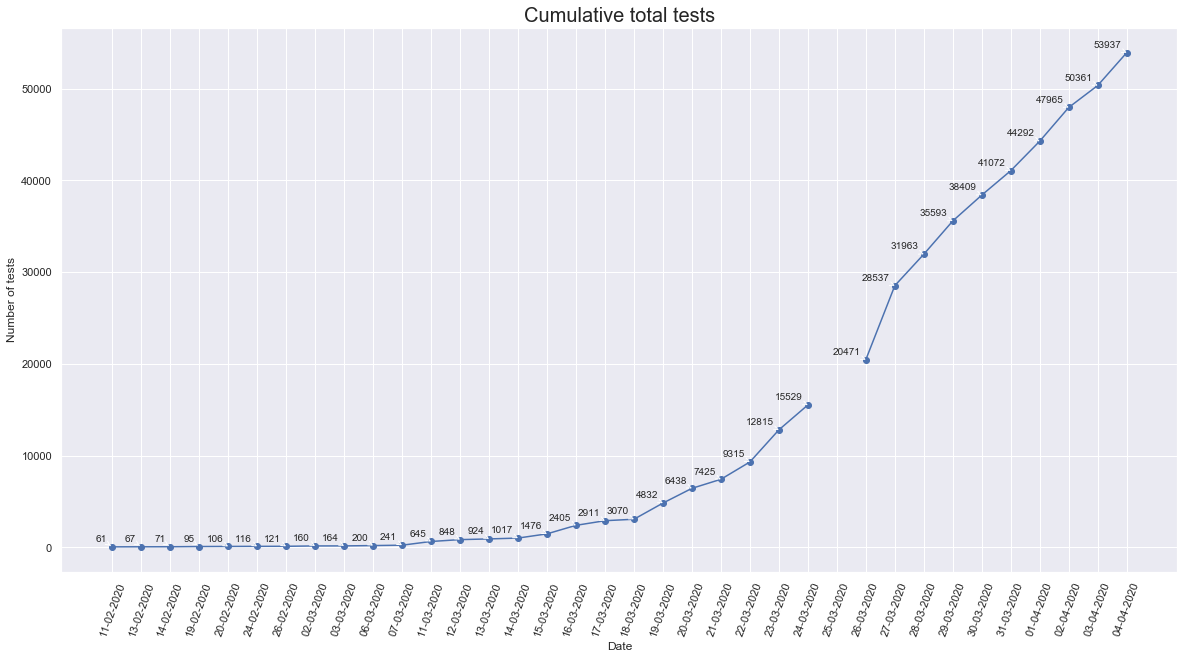

In [5]:
fig = plt.figure(figsize=[20,10]);
cov_date = pd.Series(df.cumulative_tests.values, index=df.date)
plt.xlabel('Date')
plt.tick_params(axis='x', rotation=70)
plt.ylabel('Number of tests')
plt.title('Cumulative total tests', fontsize=20)
for index, row in df.iterrows():
    if (not pd.isna(row['cumulative_tests'])):
    #print(row['date'], row['total'])
        plt.annotate('{:d}'.format(int(row['cumulative_tests'])), xy=(row['date'], row['cumulative_tests']),
                     xytext=(-5, 5), ha='right', textcoords='offset points', arrowprops=dict(arrowstyle='->', shrinkA=1))
        #plt.text(row['date'], row['total'], row['total'])
plt.plot(cov_date, 'o-')

The gap in the graph is due to missing data for that particular day. 

# Daily Testing trend for Covid-19

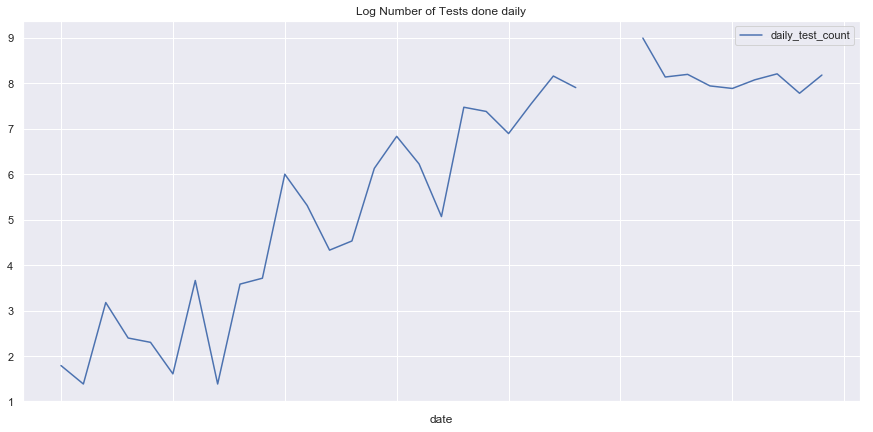

In [6]:
df3 = df.assign(daily_test_count=np.zeros(df.shape[0]))
df4 = df3.shift(periods=-1, axis='rows')
df3.daily_test_count = np.log(df4.cumulative_tests - df3.cumulative_tests)
df3.plot(x ='date', y='daily_test_count', kind = 'line', figsize=(15,7), title='Log Number of Tests done daily')

The above plot show the log of the daily test count over time, since testing was first initiated.  It can be seen that that the number of tests conducted has remained the same in the recent days. 

In [7]:
#df3.date = pd.to_datetime(df3.date, format="%d-%m-%Y")
#df.date = pd.to_datetime(df.date, format="%d-%m-%Y")
#dt = pd.to_datetime(df3.date)

Text(0.5,1,'Joint plot of Total Infections with Total Tested - on a Log scale')

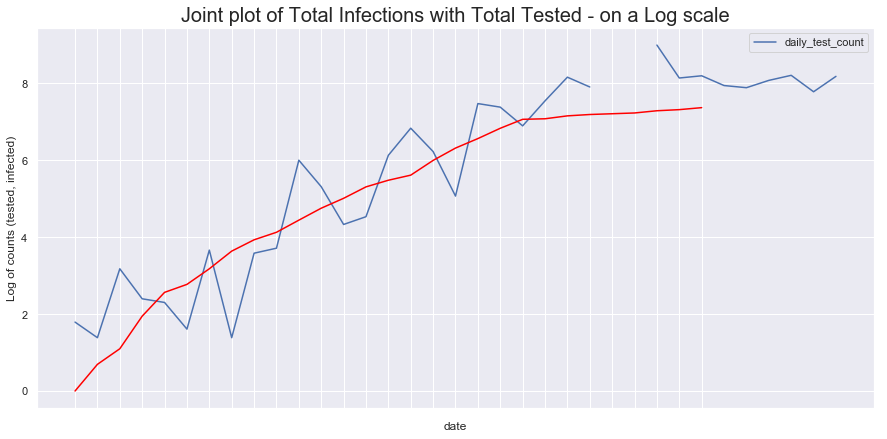

In [8]:
ax = plt.gca()

df = pd.read_csv('../data/covid19za_provincial_cumulative_timeline_confirmed.csv')

#df3.date = pd.to_datetime(df3.date, format="%d-%m-%Y")
#df.date = pd.to_datetime(df.date, format="%d-%m-%Y")

df3.plot(kind='line',x='date',y='daily_test_count', figsize=(15,7), ax=ax)
#df.plot(kind='line',x='date',y='total', logy=True, figsize=(15,7), ax=ax)
#plt.plot(df3.date, df3.daily_test_count)
plt.plot(df.date,np.log(df.total), color='red')
plt.xlabel("date")
plt.ylabel("Log of counts (tested, infected)")
plt.tick_params(axis='x', rotation=70)
plt.title('Joint plot of Total Infections with Total Tested - on a Log scale', fontsize=20)

The above plot indicates a certain degree of co-relation between the number of people tested and the number of people found to be infected.   It can be expected that as the number of tests conducted daily increases, it should pickup a higher number of infected people.  Therefore, one cannot rest easy thinking that the number of infected people is not increasing.   This is likely because we are not testing in higher numbers on a daily basis. 

# What is the distribution of age among the infected people? 

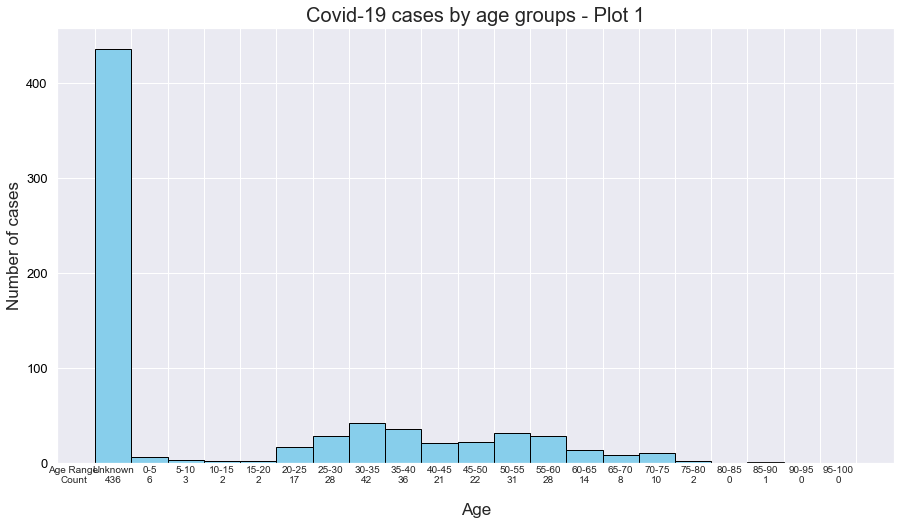

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
# read csv
df = pd.read_csv('../data/covid19za_timeline_confirmed.csv')

# replace missing age values with -5
values = {'age':-5}
df = df.fillna(value=values)

# create age bins [0,5,10....] and labels [0-4,5-9,10-14 etc]
bins = [-5]
labels = ['Unknown']
for i in range(101):
    if i%5 == 0:
        bins.append(int(i))
        if(len(bins)>2):
            labels.append(f"{str(bins[-2])}-{str(bins[-1])}")
    else:
        continue

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)

# add column to AgeGroups column to df and group all entries into the age bins [0-4, 5-9, 10-14 etc]
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

#plt.rcParams['font.family'] = 'Graphik'                        #Specify font 
# draw histogram
plt.title('Covid-19 cases by age groups - Plot 1', fontsize= 20)
plt.xlabel('Age Group', fontsize=17)
plt.ylabel('Number of cases', fontsize=17)
counts, bins, patches = plt.hist(df['age'], bins, color = "skyblue", ec='black')

# Label the raw counts and age groups below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x, label in zip(counts, bin_centers, labels):
    # Label the raw counts
    #ax.annotate(str(label) + '= ' + str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -3), textcoords='offset points', va='top', ha='center', rotation=270)
    ax.annotate(str(label), xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -3), textcoords='offset points', va='top', ha='center')
    ax.annotate(str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -13), textcoords='offset points', va='top', ha='center')
ax.annotate('Age Range', xy=(-8, 0), xycoords=('data', 'axes fraction'), xytext=(0, -3), textcoords='offset points', va='top', ha='center')
ax.annotate('Count', xy=(-8, 0), xycoords=('data', 'axes fraction'), xytext=(0, -13), textcoords='offset points', va='top', ha='center')
ax.tick_params(axis='x', labelsize=12, labelcolor='#6F6F6F', rotation=0 )  #Specify font )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#ax.axes.get_xaxis().set_visible(False)
plt.xlabel('Age', fontsize=17)
ax.tick_params(axis='y', labelsize=13, labelcolor='black')
ax.xaxis.labelpad = 40
#plt.tight_layout()
#plt.show()

The leftmost bar indicates the cases were the age was not available. 

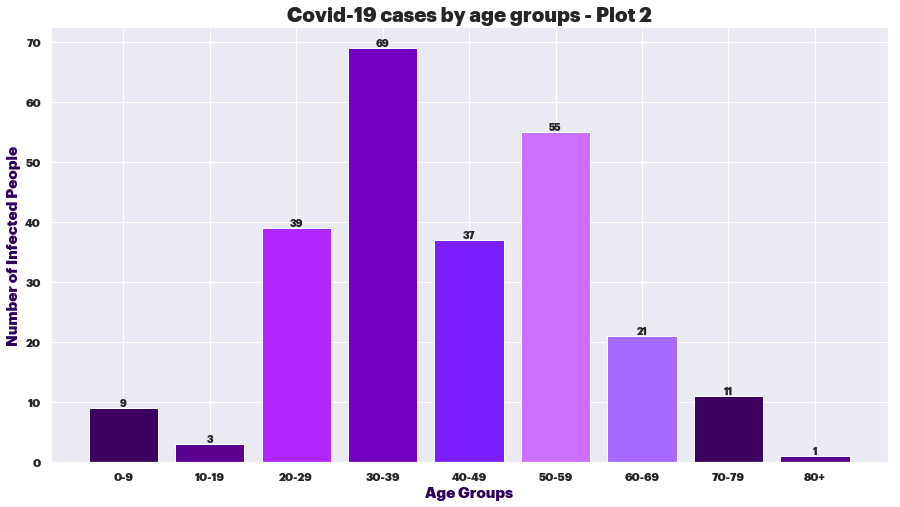

In [10]:
from collections import Counter

fig = plt.figure(figsize=[15,8]);
#Read in CSV and Group Data
countAG= {                                                #dictionary to store the number of people per age group
    "0-9": 0,
    "10-19":0,
    "20-29":0,
    "30-39":0,
    "40-49":0,
    "50-59":0,
    "60-69":0,
    "70-79":0,
    "80+":0
}

df= pd.read_csv('..\data\covid19za_timeline_confirmed.csv')        #read in csv file
ageCount= Counter(df['age'])                               #count the number of people per age (who are positive)

for i in ageCount:                                         #group each age into an age range and sum it
    if (i in range(0,9)):
        countAG["0-9"]= ageCount[i]+ countAG["0-9"]
    elif (i in range(10,19)):
        countAG["10-19"]= ageCount[i]+ countAG["10-19"]
    elif (i in range(20,29)):
        countAG["20-29"]= ageCount[i]+ countAG["20-29"]
    elif (i in range(30,39)):
        countAG["30-39"]= ageCount[i]+ countAG["30-39"]
    elif (i in range(40,49)):
        countAG["40-49"]= ageCount[i]+ countAG["40-49"]
    elif (i in range(50,59)):
        countAG["50-59"]= ageCount[i]+ countAG["50-59"]
    elif (i in range(60,69)):
        countAG["60-69"]= ageCount[i]+ countAG["60-69"]
    elif (i in range(70,79)):
        countAG["70-79"]= ageCount[i]+ countAG["70-79"]  
    elif (i >= 80):
        countAG["80+"]= ageCount[i]+ countAG["80+"]

#Start With Graph Plotting

plt.rcParams['font.family'] = 'Graphik'                        #Specify font 
plt.bar(range(len(countAG)), list(countAG.values()), color= ["#3b0060","#590090","#af26ff","#7600c0","#7c1fff","#cb6fff" ,"#a76aff","#3b0060","#590090"], align='center')  #Accenture colours added
plt.xticks(range(len(countAG)), list(countAG.keys()),fontweight='black')
plt.yticks(fontweight='black')

plt.xlabel('Age Groups', fontsize= 15,fontweight='black', color= "#2e005c")
plt.ylabel('Number of Infected People',fontsize= 15,fontweight='black', color= "#2e005c")
plt.title('Covid-19 cases by age groups - Plot 2',fontsize= 20,fontweight='black')
plt.rcParams['axes.linewidth']=0.8
#plt.grid(b=True, color='k', linestyle=':', lw=.5, zorder=1)   #Optional grid lines

xs=[0,1,2,3,4,5,6,7,8]                                         #Necessary to form x,y pair

for x,y in zip(xs,list(countAG.values())):

    label = y

    plt.annotate(label,                                        # this is the text
                 (x,y),                                        # this is the point to label
                 textcoords="offset points",                   # how to position the text
                 xytext=(0,2),                                 # distance from text to points (x,y)
                 ha='center',                                  # horizontal alignment can be left, right or center
                 fontweight='black')                           # make labels bold


This does not include positive cases whose age is not known - which is shown in the bar graph above this one. 

# Further areas to explore


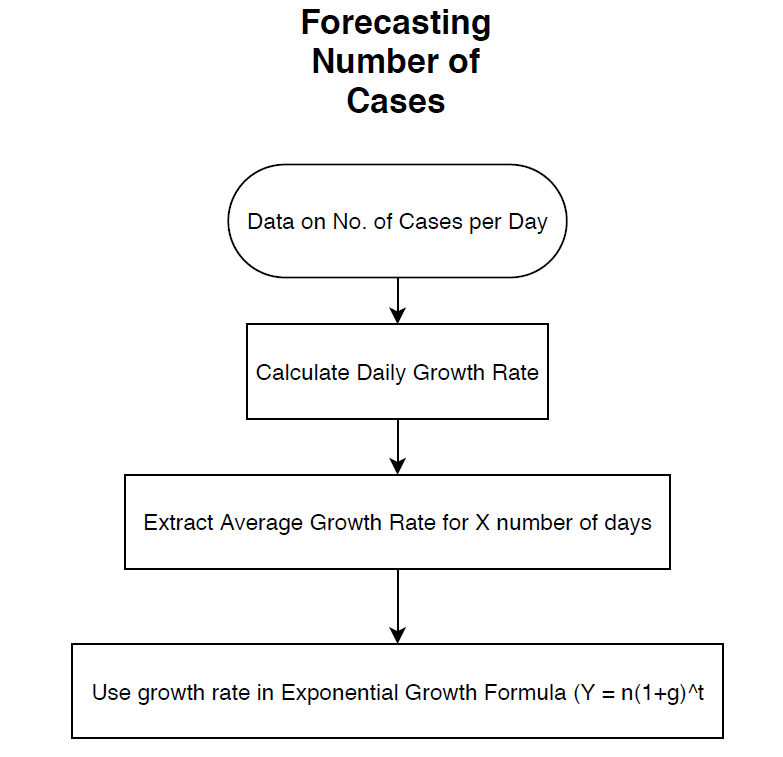

In [11]:
from IPython.display import Image, display
display(Image(filename='images/forecast_cases.png', embed=True))

## Calculating a Daily Growth Rate: 

In [12]:
df_growth = pd.read_csv('../data/covid19za_provincial_cumulative_timeline_confirmed.csv')
df_growth.head()
df_growth["Previous cases"] = df_growth["total"].shift(1)
df_growth["Daily Growth Rate"] = (df_growth["total"] - df_growth["Previous cases"]) / df_growth["Previous cases"] * 100

print("Average Daily Growth Rate:")
print(df_growth["Daily Growth Rate"].mean())
print( " ")

recent_growth_rate = df_growth.iloc[len(df_growth)-3:len(df_growth),-1].mean()
print("3 Day Growth Rate:")
print(recent_growth_rate)

print( " ")
print("Number of Cases Double Every:")
print(str((100/recent_growth_rate)) + " days")


Average Daily Growth Rate:
33.119210426317544
 
3 Day Growth Rate:
4.73294002467856
 
Number of Cases Double Every:
21.12851620315885 days


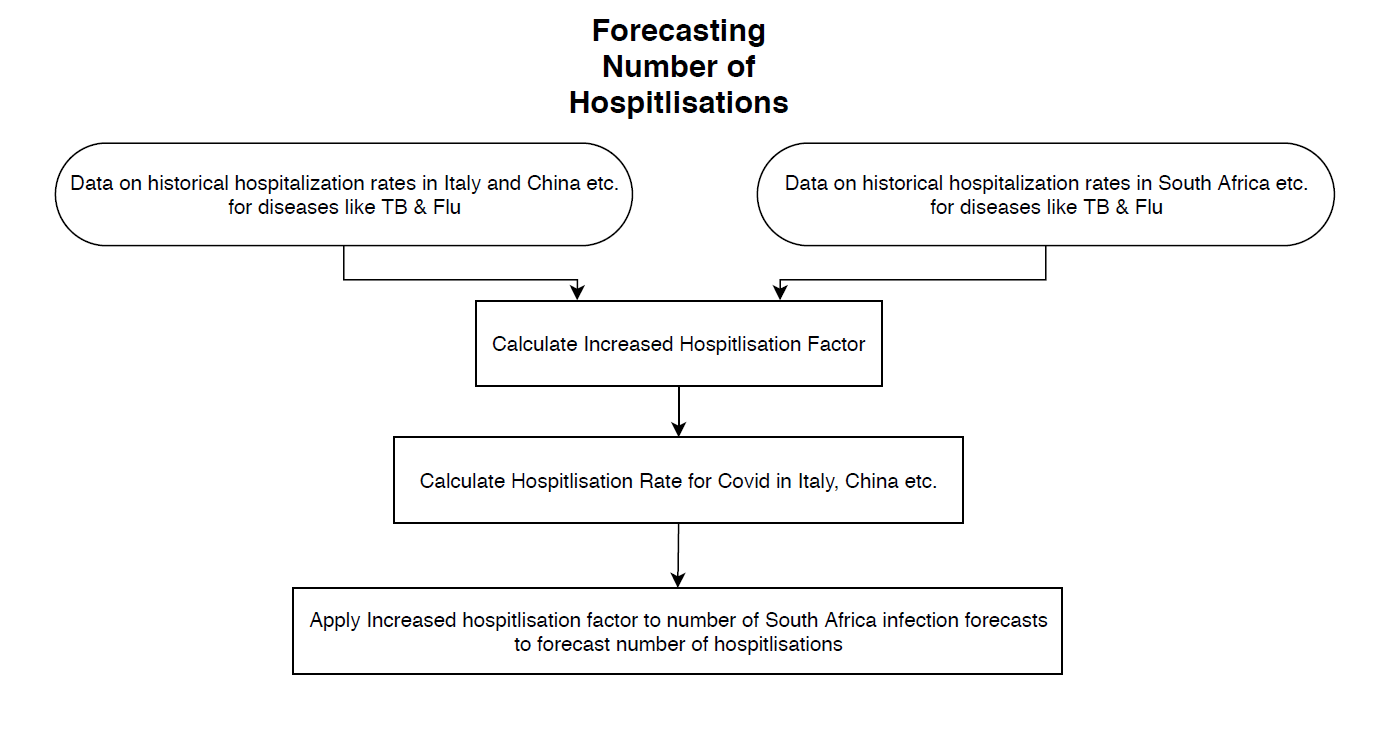

In [13]:
from IPython.display import Image, display
display(Image(filename='images/forecast_hospitalizations.png', embed=True))

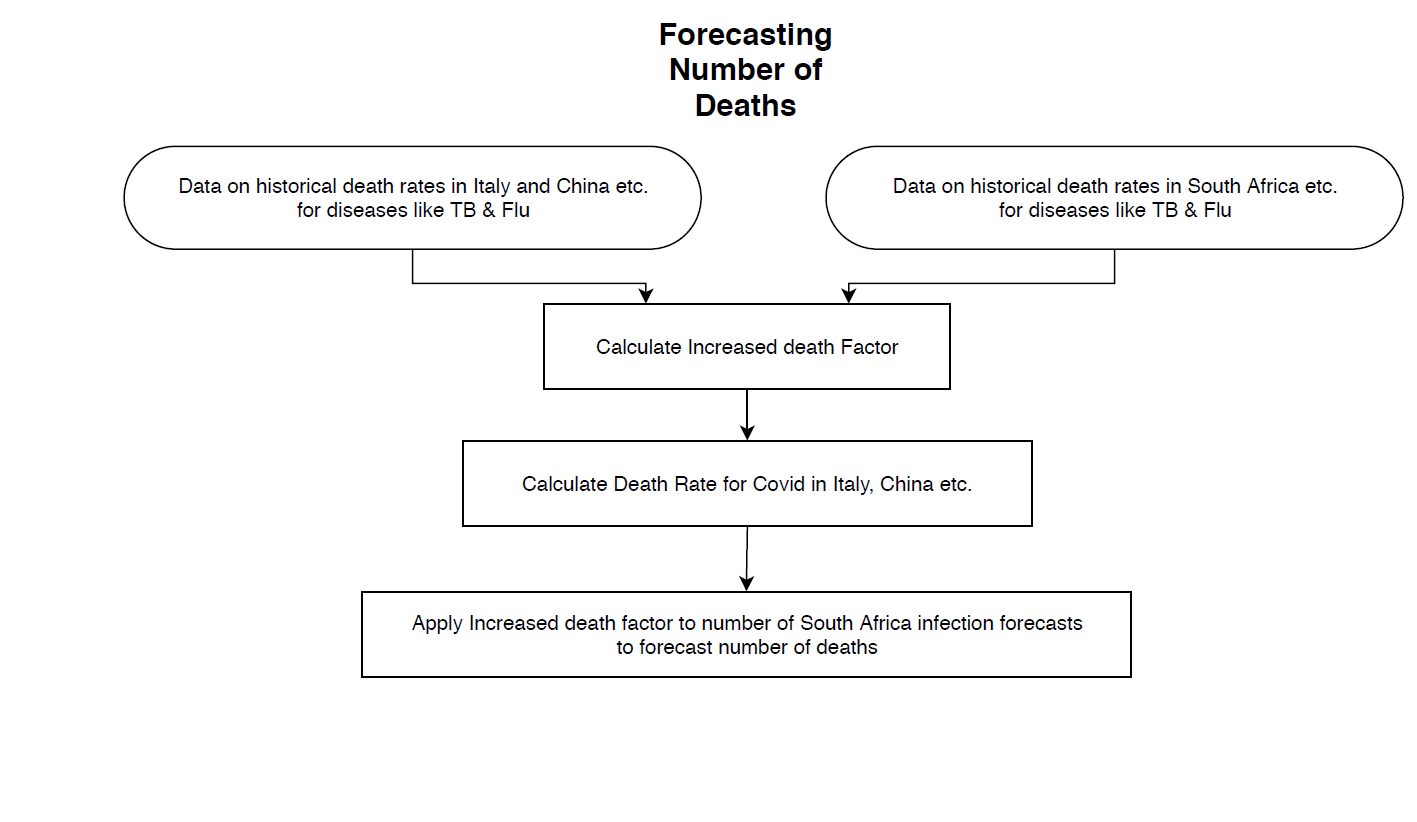

In [14]:
from IPython.display import Image, display
display(Image(filename='images/forecast_deaths.png', embed=True))